In [1]:
import os
import cv2
import glob
import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VOC Dataset

In [2]:
def load_images_and_anns(im_dir, ann_dir, label2idx):
    im_infos = []
    for ann_file in tqdm(glob.glob(os.path.join(ann_dir, '*.xml'))):
        im_info = {}
        im_info['img_id'] = os.path.basename(ann_file).split('.xml')[0]
        im_info['filename'] = os.path.join(im_dir, '{}.jpg'.format(im_info['img_id']))
        ann_info = ET.parse(ann_file)
        root = ann_info.getroot()
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        im_info['width'] = width
        im_info['height'] = height
        detections = []
        
        for obj in ann_info.findall('object'):
            det = {}
            label = label2idx[obj.find('name').text]
            bbox_info = obj.find('bndbox')
            bbox = [
                int(float(bbox_info.find('xmin').text))-1,
                int(float(bbox_info.find('ymin').text))-1,
                int(float(bbox_info.find('xmax').text))-1,
                int(float(bbox_info.find('ymax').text))-1
            ]
            det['label'] = label
            det['bbox'] = bbox
            detections.append(det)
        im_info['detections'] = detections
        im_infos.append(im_info)
    print('Total {} images found'.format(len(im_infos)))
    return im_infos

In [3]:
class VOCDataset(Dataset):
    def __init__(self, split, im_dir, ann_dir):
        self.split = split
        self.im_dir = im_dir
        self.ann_dir = ann_dir
        classes = [
            'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
            'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
            'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor'
        ]
        classes = sorted(classes)
        classes = ['background'] + classes
        self.label2idx = {classes[idx]: idx for idx in range(len(classes))}
        self.idx2label = {idx: classes[idx] for idx in range(len(classes))}
        print(self.idx2label)
        self.images_info = load_images_and_anns(im_dir, ann_dir, self.label2idx)
        
    def __len__(self):
        return len(self.images_info)
        
    def __getitem__(self, index):
        im_info = self.images_info[index]
        im = Image.open(im_info['filename'])
        to_flip = False
        if self.split == 'train' and random.random() < 0.5:
            to_flip = True
            im = im.transpose(Image.FLIP_LEFT_RIGHT)
        im_tensor = torchvision.transforms.ToTensor()(im)
        targets = {}
        targets['bboxes'] = torch.as_tensor([detection['bbox'] for detection in im_info['detections']])
        targets['labels'] = torch.as_tensor([detection['label'] for detection in im_info['detections']])
        if to_flip:
            for idx, box in enumerate(targets['bboxes']):
                x1, y1, x2, y2 = box
                w = x2-x1
                im_w = im_tensor.shape[-1]
                x1 = im_w - x1 - w
                x2 = x1 + w
                targets['bboxes'][idx] = torch.as_tensor([x1, y1, x2, y2])
        return im_tensor, targets, im_info['filename']

In [4]:
im_dir = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
ann_dir = '/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations'

voc = VOCDataset('train',im_dir=im_dir,ann_dir=ann_dir)

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


100%|██████████| 5011/5011 [00:22<00:00, 217.99it/s]

Total 5011 images found


In [5]:
train_dataset = DataLoader(voc,batch_size=1,shuffle=True,num_workers=4)

In [6]:
voc.idx2label[0]

'background'

/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/003492.jpg
torch.Size([1, 3, 366, 500])


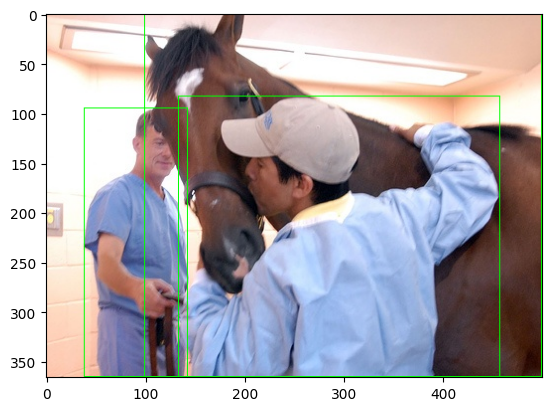

In [7]:
for data in train_dataset:
    
    print(data[2][0])
    image = cv2.imread(data[2][0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_clone = np.copy(image)
    bbox = data[1]['bboxes'][0]
    for i in range(len(bbox)):
        x0, y0, x1, y1 = bbox[i].numpy()
        cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0, 255, 0), thickness=1)
    print(data[0].shape)
    plt.imshow(img_clone)
    break

# Helper Function 

In [8]:
def sample_positive_negative(labels, positive_count, total_count):
    # Sample positive and negative proposals
    positive = torch.where(labels >= 1)[0]
    negative = torch.where(labels == 0)[0]
    num_pos = positive_count
    num_pos = min(positive.numel(), num_pos)
    num_neg = total_count - num_pos
    num_neg = min(negative.numel(), num_neg)
    perm_positive_idxs = torch.randperm(positive.numel(),
                                        device=positive.device)[:num_pos]
    perm_negative_idxs = torch.randperm(negative.numel(),
                                        device=negative.device)[:num_neg]
    pos_idxs = positive[perm_positive_idxs]
    neg_idxs = negative[perm_negative_idxs]
    sampled_pos_idx_mask = torch.zeros_like(labels, dtype=torch.bool)
    sampled_neg_idx_mask = torch.zeros_like(labels, dtype=torch.bool)
    sampled_pos_idx_mask[pos_idxs] = True
    sampled_neg_idx_mask[neg_idxs] = True
    return sampled_neg_idx_mask, sampled_pos_idx_mask

In [9]:
def boxes_to_transformation_targets(ground_truth_boxes, anchors_or_proposals):
    
    # Get center_x,center_y,w,h from x1,y1,x2,y2 for anchors
    widths = anchors_or_proposals[:, 2] - anchors_or_proposals[:, 0]
    heights = anchors_or_proposals[:, 3] - anchors_or_proposals[:, 1]
    center_x = anchors_or_proposals[:, 0] + 0.5 * widths
    center_y = anchors_or_proposals[:, 1] + 0.5 * heights
    
    # Get center_x,center_y,w,h from x1,y1,x2,y2 for gt boxes
    gt_widths = ground_truth_boxes[:, 2] - ground_truth_boxes[:, 0]
    gt_heights = ground_truth_boxes[:, 3] - ground_truth_boxes[:, 1]
    gt_center_x = ground_truth_boxes[:, 0] + 0.5 * gt_widths
    gt_center_y = ground_truth_boxes[:, 1] + 0.5 * gt_heights
    
    targets_dx = (gt_center_x - center_x) / widths
    targets_dy = (gt_center_y - center_y) / heights
    targets_dw = torch.log(gt_widths / widths)
    targets_dh = torch.log(gt_heights / heights)
    regression_targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return regression_targets

In [10]:
def apply_regression_pred_to_anchors_or_proposals(box_transform_pred, anchors_or_proposals):

    box_transform_pred = box_transform_pred.reshape(
        box_transform_pred.size(0), -1, 4)
    
    # Get cx, cy, w, h from x1,y1,x2,y2
    w = anchors_or_proposals[:, 2] - anchors_or_proposals[:, 0]
    h = anchors_or_proposals[:, 3] - anchors_or_proposals[:, 1]
    center_x = anchors_or_proposals[:, 0] + 0.5 * w
    center_y = anchors_or_proposals[:, 1] + 0.5 * h
    
    dx = box_transform_pred[..., 0]
    dy = box_transform_pred[..., 1]
    dw = box_transform_pred[..., 2]
    dh = box_transform_pred[..., 3]
    # dh -> (num_anchors_or_proposals, num_classes)
    
    # Prevent sending too large values into torch.exp()
    dw = torch.clamp(dw, max=math.log(1000.0 / 16))
    dh = torch.clamp(dh, max=math.log(1000.0 / 16))
    
    pred_center_x = dx * w[:, None] + center_x[:, None]
    pred_center_y = dy * h[:, None] + center_y[:, None]
    pred_w = torch.exp(dw) * w[:, None]
    pred_h = torch.exp(dh) * h[:, None]
    # pred_center_x -> (num_anchors_or_proposals, num_classes)
    
    pred_box_x1 = pred_center_x - 0.5 * pred_w
    pred_box_y1 = pred_center_y - 0.5 * pred_h
    pred_box_x2 = pred_center_x + 0.5 * pred_w
    pred_box_y2 = pred_center_y + 0.5 * pred_h
    
    pred_boxes = torch.stack((
        pred_box_x1,
        pred_box_y1,
        pred_box_x2,
        pred_box_y2),
        dim=2)
    # pred_boxes -> (num_anchors_or_proposals, num_classes, 4)
    return pred_boxes


In [11]:
def get_iou(boxes1, boxes2):
     # If already tensors, detach safely; if not, convert
    if isinstance(boxes1, torch.Tensor):
        boxes1 = boxes1.clone().detach()
    else:
        boxes1 = torch.tensor(boxes1, dtype=torch.float32)

    if isinstance(boxes2, torch.Tensor):
        boxes2 = boxes2.clone().detach()
    else:
        boxes2 = torch.tensor(boxes2, dtype=torch.float32)
    
    # Area of boxes (x2-x1)*(y2-y1)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # (N,)
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # (M,)
    
    # Get top left x1,y1 coordinate
    x_left = torch.max(boxes1[:, None, 0], boxes2[:, 0])  # (N, M)
    y_top = torch.max(boxes1[:, None, 1], boxes2[:, 1])  # (N, M)
    
    # Get bottom right x2,y2 coordinate
    x_right = torch.min(boxes1[:, None, 2], boxes2[:, 2])  # (N, M)
    y_bottom = torch.min(boxes1[:, None, 3], boxes2[:, 3])  # (N, M)
    
    intersection_area = (x_right - x_left).clamp(min=0) * (y_bottom - y_top).clamp(min=0)  
    union = area1[:, None] + area2 - intersection_area  
    iou = intersection_area / union  # (N, M)
    return iou

In [12]:
def clamp_boxes_to_image_boundary(boxes, image_shape):
    boxes_x1 = boxes[..., 0]
    boxes_y1 = boxes[..., 1]
    boxes_x2 = boxes[..., 2]
    boxes_y2 = boxes[..., 3]
    height, width = image_shape[-2:]
    boxes_x1 = boxes_x1.clamp(min=0, max=width)
    boxes_x2 = boxes_x2.clamp(min=0, max=width)
    boxes_y1 = boxes_y1.clamp(min=0, max=height)
    boxes_y2 = boxes_y2.clamp(min=0, max=height)
    boxes = torch.cat((
        boxes_x1[..., None],
        boxes_y1[..., None],
        boxes_x2[..., None],
        boxes_y2[..., None]),
        dim=-1)
    return boxes

In [13]:
def transform_boxes_to_original_size(boxes, new_size, original_size):
    
    ratios = [
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        / torch.tensor(s, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

# Region Proposal Network Class

In [14]:
def filter_proposals(self, proposals, cls_scores, image_shape):
        
        # Pre NMS Filtering
        cls_scores = cls_scores.reshape(-1)
        cls_scores = torch.sigmoid(cls_scores)
        _, top_n_idx = cls_scores.topk(2000)
        
        cls_scores = cls_scores[top_n_idx]
        proposals = proposals[top_n_idx]
        
        # Clamp boxes to image boundary
        proposals = clamp_boxes_to_image_boundary(proposals, image_shape)
        
        # Small boxes based on width and height filtering
        min_size = 16
        ws, hs = proposals[:, 2] - proposals[:, 0], proposals[:, 3] - proposals[:, 1]
        keep = (ws >= min_size) & (hs >= min_size)
        keep = torch.where(keep)[0]
        proposals = proposals[keep]
        cls_scores = cls_scores[keep]
        
        # NMS based on objectness scores
        keep_mask = torch.zeros_like(cls_scores, dtype=torch.bool)
        keep_indices = torch.ops.torchvision.nms(proposals, cls_scores, 0.7)
        keep_mask[keep_indices] = True
        keep_indices = torch.where(keep_mask)[0]
        # Sort by objectness
        post_nms_keep_indices = keep_indices[cls_scores[keep_indices].sort(descending=True)[1]]
        
        # Post NMS topk filtering
        proposals, cls_scores = (proposals[post_nms_keep_indices[:2000]],
                                 cls_scores[post_nms_keep_indices[:2000]])
        
        return proposals, cls_scores

In [15]:
def assign_targets_to_anchors(self, anchors, gt_boxes):
        
        iou_matrix = get_iou(gt_boxes, anchors)
        
        # For each anchor get the gt box index with maximum overlap
        best_match_iou, best_match_gt_idx = iou_matrix.max(dim=0)
        # best_match_gt_idx -> (num_anchors_in_image)
        
        # add low quality matches
        best_match_gt_idx_pre_thresholding = best_match_gt_idx.clone()
        
        below_low_threshold = best_match_iou < 0.3
        between_thresholds = (best_match_iou >= 0.3) & (best_match_iou < 0.7)
        best_match_gt_idx[below_low_threshold] = -1
        best_match_gt_idx[between_thresholds] = -2
        
        # For each gt box, get the maximum IOU value amongst all anchors
        best_anchor_iou_for_gt, _ = iou_matrix.max(dim=1)
        # best_anchor_iou_for_gt -> (num_gt_boxes_in_image)
        
        gt_pred_pair_with_highest_iou = torch.where(iou_matrix == best_anchor_iou_for_gt[:, None])
        
        # Get all the anchors indexes to update
        pred_inds_to_update = gt_pred_pair_with_highest_iou[1]
        best_match_gt_idx[pred_inds_to_update] = best_match_gt_idx_pre_thresholding[pred_inds_to_update]
        
        # best_match_gt_idx is either a valid index for all anchors or -1(background) or -2(to be ignored)
        matched_gt_boxes = gt_boxes[best_match_gt_idx.clamp(min=0)]
        
        # Set all foreground anchor labels as 1
        labels = best_match_gt_idx >= 0
        labels = labels.to(dtype=torch.float32)
        
        # Set all background anchor labels as 0
        background_anchors = best_match_gt_idx == -1
        labels[background_anchors] = 0.0
        
        # Set all to be ignored anchor labels as -1
        ignored_anchors = best_match_gt_idx == -2
        labels[ignored_anchors] = -1.0
        
        return labels, matched_gt_boxes

In [16]:
def generate_anchors(self, image, feat):
        grid_h, grid_w = feat.shape[-2:]
        image_h, image_w = image.shape[-2:]
        
        # For the vgg16 case stride would be 16 for both h and w
        stride_h = torch.tensor(image_h // grid_h, dtype=torch.int64, device=feat.device)
        stride_w = torch.tensor(image_w // grid_w, dtype=torch.int64, device=feat.device)
        
        scales = torch.as_tensor(self.scales, dtype=feat.dtype, device=feat.device)
        aspect_ratios = torch.as_tensor(self.aspect_ratios, dtype=feat.dtype, device=feat.device)

        #ensures h/w = aspect_ratios and h*w=1
        h_ratios = torch.sqrt(aspect_ratios)
        w_ratios = 1 / h_ratios

         # This gives us the widths and heights of all anchors
        ws = (w_ratios[:, None] * scales[None, :]).view(-1)
        hs = (h_ratios[:, None] * scales[None, :]).view(-1)

        # So x1, y1, x2, y2 = -w/2, -h/2, w/2, h/2
        base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
        base_anchors = base_anchors.round()

        # Get the shifts in x axis (0, 1,..., W_feat-1) * stride_w
        shifts_x = torch.arange(0, grid_w, dtype=torch.int32, device=feat.device) * stride_w

        # Get the shifts in y axis (0, 1,..., H_feat-1) * stride_h
        shifts_y = torch.arange(0, grid_h, dtype=torch.int32, device=feat.device) * stride_h
    
        # Create a grid using these shifts
        shifts_y, shifts_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")

        shifts_x = shifts_x.reshape(-1)
        shifts_y = shifts_y.reshape(-1)

        shifts = torch.stack((shifts_x, shifts_y, shifts_x, shifts_y), dim=1)

        # Add these shifts to each of the base anchors
        anchors = (shifts.view(-1, 1, 4) + base_anchors.view(1, -1, 4)) # anchors -> (H_feat * W_feat, num_anchors_per_location, 4)
        anchors = anchors.reshape(-1, 4) # anchors -> (H_feat * W_feat * num_anchors_per_location, 4)
    
        return anchors

In [17]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels=512):
        super(RegionProposalNetwork, self).__init__()
        self.scales = [128, 256, 512]
        self.aspect_ratios = [0.5, 1, 2]
        self.num_anchors = len(self.scales) * len(self.aspect_ratios)

        # 3x3 conv
        self.rpn_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

        # 1x1 classification
        self.cls_layer = nn.Conv2d(in_channels, self.num_anchors, kernel_size=1, stride=1)

        # 1x1 regression
        self.bbox_reg_layer = nn.Conv2d(in_channels, self.num_anchors * 4, kernel_size=1, stride=1)
        
    def forward(self, image, feat, target):
        # call rpn layer
        rpn_feat = nn.ReLU()(self.rpn_conv(feat))
        cls_scores = self.cls_layer(rpn_feat)
        box_transform_pred = self.bbox_reg_layer(rpn_feat)

        # Generate anchors
        anchors = self.generate_anchors(image, feat)
        
        # cls_score -> (Batch_Size, Number of Anchors per location, H_feat, W_feat)
        number_of_anchors_per_location = cls_scores.size(1)
        cls_scores = cls_scores.permute(0, 2, 3, 1)
        cls_scores = cls_scores.reshape(-1, 1) 
        # cls_score -> (Batch_Size*H_feat*W_feat*Number of Anchors per location, 1)
        
        # box_transform_pred -> (Batch_Size, Number of Anchors per location*4, H_feat, W_feat)
        box_transform_pred = box_transform_pred.view(
            box_transform_pred.size(0),
            number_of_anchors_per_location,
            4,
            rpn_feat.shape[-2],
            rpn_feat.shape[-1])
        box_transform_pred = box_transform_pred.permute(0, 3, 4, 1, 2)
        box_transform_pred = box_transform_pred.reshape(-1, 4)  
        # box_transform_pred -> (Batch_Size*H_feat*W_feat*Number of Anchors per location, 4)

        # Transform generated anchors according to box transformation prediction
        proposals = apply_regression_pred_to_anchors_or_proposals(
            box_transform_pred.detach().reshape(-1, 1, 4),
            anchors)
        proposals = proposals.reshape(proposals.size(0), 4)
        
        proposals, scores = self.filter_proposals(proposals, cls_scores.detach(), image.shape)
        rpn_output = {
            'proposals': proposals,
            'scores': scores
        }

        if not self.training or target is None:
            # not training do nothing
            return rpn_output
        else:
            # Assign gt box and label for each anchor
            labels_for_anchors, matched_gt_boxes_for_anchors = self.assign_targets_to_anchors(anchors,target['bboxes'][0])
            
            # matched_gt_boxes_for_anchors -> (Number of anchors in image, 4)
            # anchors -> (Number of anchors in image, 4)
            regression_targets = boxes_to_transformation_targets(matched_gt_boxes_for_anchors, anchors)

            # Our labels were {fg:1, bg:0, to_be_ignored:-1}
            sampled_neg_idx_mask, sampled_pos_idx_mask = sample_positive_negative(
                labels_for_anchors,
                positive_count=128,
                total_count=256)
            
            sampled_idxs = torch.where(sampled_pos_idx_mask | sampled_neg_idx_mask)[0]

            localization_loss = (
                    torch.nn.functional.smooth_l1_loss(box_transform_pred[sampled_pos_idx_mask],regression_targets[sampled_pos_idx_mask],
                        beta=1 / 9,reduction="sum",)/ (sampled_idxs.numel())) 
            
            cls_loss = torch.nn.functional.binary_cross_entropy_with_logits(cls_scores[sampled_idxs].flatten(),
                                                                            labels_for_anchors[sampled_idxs].flatten())
            
            rpn_output['rpn_classification_loss'] = cls_loss
            rpn_output['rpn_localization_loss'] = localization_loss
            return rpn_output

            


RegionProposalNetwork.generate_anchors = generate_anchors
RegionProposalNetwork.filter_proposals = filter_proposals
RegionProposalNetwork.assign_targets_to_anchors = assign_targets_to_anchors

# ROI Head Class

In [18]:
def assign_target_to_proposals(self, proposals, gt_boxes, gt_labels):
    
    iou_matrix = get_iou(gt_boxes, proposals)    
    best_match_iou, best_match_gt_idx = iou_matrix.max(dim=0)
    background_proposals = (best_match_iou < 0.5) & (best_match_iou >= 0.1)
    ignored_proposals = best_match_iou < 0.1   
    
    best_match_gt_idx[background_proposals] = -1
    best_match_gt_idx[ignored_proposals] = -2    
        
    matched_gt_boxes_for_proposals = gt_boxes[best_match_gt_idx.clamp(min=0)]
            
    labels = gt_labels[best_match_gt_idx.clamp(min=0)]
    labels = labels.to(dtype=torch.int64)
        
    labels[background_proposals] = 0
            
    labels[ignored_proposals] = -1
        
    return labels, matched_gt_boxes_for_proposals

In [19]:
def filter_predictions(self, pred_boxes, pred_labels, pred_scores):
        # remove low scoring boxes
        keep = torch.where(pred_scores > 0.05)[0]
        pred_boxes, pred_scores, pred_labels = pred_boxes[keep], pred_scores[keep], pred_labels[keep]
        
        # Remove small boxes
        min_size = 16
        ws, hs = pred_boxes[:, 2] - pred_boxes[:, 0], pred_boxes[:, 3] - pred_boxes[:, 1]
        keep = (ws >= min_size) & (hs >= min_size)
        keep = torch.where(keep)[0]
        pred_boxes, pred_scores, pred_labels = pred_boxes[keep], pred_scores[keep], pred_labels[keep]
        
        # Class wise nms
        keep_mask = torch.zeros_like(pred_scores, dtype=torch.bool)
        for class_id in torch.unique(pred_labels):
            curr_indices = torch.where(pred_labels == class_id)[0]
            curr_keep_indices = torch.ops.torchvision.nms(pred_boxes[curr_indices],
                                                          pred_scores[curr_indices],
                                                          0.5)
            keep_mask[curr_indices[curr_keep_indices]] = True
        keep_indices = torch.where(keep_mask)[0]
        post_nms_keep_indices = keep_indices[pred_scores[keep_indices].sort(descending=True)[1]]
        keep = post_nms_keep_indices[:100]
        pred_boxes, pred_scores, pred_labels = pred_boxes[keep], pred_scores[keep], pred_labels[keep]
        return pred_boxes, pred_labels, pred_scores

In [20]:
class ROIHead(nn.Module):
    def __init__(self, num_classes=21, in_channels=512):
        super(ROIHead, self).__init__()
        self.num_classes = num_classes
        self.pool_size = 7
        self.fc_inner_dim = 1024

        self.fc6 = nn.Linear(in_channels * self.pool_size * self.pool_size, self.fc_inner_dim)
        self.fc7 = nn.Linear(self.fc_inner_dim, self.fc_inner_dim)
        self.cls_layer = nn.Linear(self.fc_inner_dim, self.num_classes)
        self.bbox_reg_layer = nn.Linear(self.fc_inner_dim, self.num_classes * 4)
                                        
    def forward(self, feat, proposals, image_shape, target):    
        if self.training and target is not None:
            proposals = torch.cat([proposals, target['bboxes'][0]], dim=0)
        
            gt_boxes = target['bboxes'][0]
            gt_labels = target['labels'][0]
        
            labels, matched_gt_boxes_for_proposals = self.assign_target_to_proposals(proposals, gt_boxes, gt_labels)
        
            sampled_neg_idx_mask, sampled_pos_idx_mask = sample_positive_negative(labels,positive_count=32,total_count=128)
            sampled_idxs = torch.where(sampled_pos_idx_mask | sampled_neg_idx_mask)[0]
        
            proposals = proposals[sampled_idxs]
            labels = labels[sampled_idxs]
            matched_gt_boxes_for_proposals = matched_gt_boxes_for_proposals[sampled_idxs]
            regression_targets = boxes_to_transformation_targets(matched_gt_boxes_for_proposals, proposals)

        spatial_scale = 0.0625
        # ROI pooling and call all layers for prediction
        proposal_roi_pool_feats = torchvision.ops.roi_pool(feat, [proposals],
                                                           output_size=self.pool_size,
                                                           spatial_scale=spatial_scale)
        
        proposal_roi_pool_feats = proposal_roi_pool_feats.flatten(start_dim=1)
        box_fc_6 = torch.nn.functional.relu(self.fc6(proposal_roi_pool_feats))
        box_fc_7 = torch.nn.functional.relu(self.fc7(box_fc_6))
        cls_scores = self.cls_layer(box_fc_7)
        box_transform_pred = self.bbox_reg_layer(box_fc_7)

        num_boxes, num_classes = cls_scores.shape
        box_transform_pred = box_transform_pred.reshape(num_boxes, num_classes, 4)
        
        frcnn_output = {}
        if self.training and target is not None:
            classification_loss = torch.nn.functional.cross_entropy(cls_scores, labels)
            # Compute localization loss only for non-background labelled proposals
            fg_proposals_idxs = torch.where(labels > 0)[0]
            # Get class labels for these positive proposals
            fg_cls_labels = labels[fg_proposals_idxs]
            
            localization_loss = torch.nn.functional.smooth_l1_loss(
                box_transform_pred[fg_proposals_idxs, fg_cls_labels],
                regression_targets[fg_proposals_idxs],
                beta=1/9,
                reduction="sum",
            )
            
            localization_loss = localization_loss / labels.numel()
            
            frcnn_output['frcnn_classification_loss'] = classification_loss
            frcnn_output['frcnn_localization_loss'] = localization_loss
            
        if self.training:
            return frcnn_output
        else:
            device = cls_scores.device
            # Apply transformation predictions to proposals
            pred_boxes = apply_regression_pred_to_anchors_or_proposals(box_transform_pred, proposals)
            pred_scores = torch.nn.functional.softmax(cls_scores, dim=-1)
            
            # Clamp box to image boundary
            pred_boxes = clamp_boxes_to_image_boundary(pred_boxes, image_shape)
            
            # create labels for each prediction
            pred_labels = torch.arange(num_classes, device=device)
            pred_labels = pred_labels.view(1, -1).expand_as(pred_scores)
            
            # remove predictions with the background label
            pred_boxes = pred_boxes[:, 1:]
            pred_scores = pred_scores[:, 1:]
            pred_labels = pred_labels[:, 1:]
            
            # pred_boxes -> (number_proposals, num_classes-1, 4)
            # pred_scores -> (number_proposals, num_classes-1)
            # pred_labels -> (number_proposals, num_classes-1)
            
            pred_boxes = pred_boxes.reshape(-1, 4)
            pred_scores = pred_scores.reshape(-1)
            pred_labels = pred_labels.reshape(-1)
            
            pred_boxes, pred_labels, pred_scores = self.filter_predictions(pred_boxes, pred_labels, pred_scores)
            frcnn_output['boxes'] = pred_boxes
            frcnn_output['scores'] = pred_scores
            frcnn_output['labels'] = pred_labels
            return frcnn_output


ROIHead.assign_target_to_proposals = assign_target_to_proposals
ROIHead.filter_predictions = filter_predictions

# Faster R-CNN Class 

In [21]:
def normalize_resize_image_and_boxes(self, image, bboxes):
        dtype, device = image.dtype, image.device
        
        # Normalize
        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        image = (image - mean[:, None, None]) / std[:, None, None]
        
        # Resize to 1000x600 such that lowest size dimension is scaled upto 600
        # but larger dimension is not more than 1000
        h, w = image.shape[-2:]
        im_shape = torch.tensor(image.shape[-2:])
        min_size = torch.min(im_shape).to(dtype=torch.float32)
        max_size = torch.max(im_shape).to(dtype=torch.float32)
        scale = torch.min(float(self.min_size) / min_size, float(self.max_size) / max_size)
        scale_factor = scale.item()
        
        # Resize image based on scale computed
        image = torch.nn.functional.interpolate(
            image,
            size=None,
            scale_factor=scale_factor,
            mode="bilinear",
            recompute_scale_factor=True,
            align_corners=False,
        )

        if bboxes is not None:
            # Resize boxes by
            ratios = [
                torch.tensor(s, dtype=torch.float32, device=bboxes.device)
                / torch.tensor(s_orig, dtype=torch.float32, device=bboxes.device)
                for s, s_orig in zip(image.shape[-2:], (h, w))
            ]
            ratio_height, ratio_width = ratios
            xmin, ymin, xmax, ymax = bboxes.unbind(2)
            xmin = xmin * ratio_width
            xmax = xmax * ratio_width
            ymin = ymin * ratio_height
            ymax = ymax * ratio_height
            bboxes = torch.stack((xmin, ymin, xmax, ymax), dim=2)
        return image, bboxes

In [22]:
class FasterRCNN(nn.Module):
    def __init__(self, num_classes = 21):
        super(FasterRCNN, self).__init__()
        vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        self.backbone = vgg16.features[:-1]
        self.rpn = RegionProposalNetwork(in_channels=512)
        self.roi_head = ROIHead(num_classes = num_classes, 
                                in_channels=512)
        for layer in self.backbone[:10]:
            for p in layer.parameters():
                p.requires_grad = False
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]
        self.min_size = 600
        self.max_size = 1000
    def forward(self, image, target=None):
        old_shape = image.shape[-2:]
        if self.training:
            # Normalize and resize boxes
            image, bboxes = self.normalize_resize_image_and_boxes(image, target['bboxes'])
            target['bboxes'] = bboxes
        else:
            image, _ = self.normalize_resize_image_and_boxes(image, None)

         # Call backbone
        feat = self.backbone(image)
        
        # Call RPN and get proposals
        rpn_output = self.rpn(image, feat, target)
        proposals = rpn_output['proposals']
        
        # Call ROI head and convert proposals to boxes
        frcnn_output = self.roi_head(feat, proposals, image.shape[-2:], target)
        if not self.training:
            # Transform boxes to original image dimensions called only during inference
            frcnn_output['boxes'] = transform_boxes_to_original_size(frcnn_output['boxes'],
                                                                     image.shape[-2:],
                                                                     old_shape)
        return rpn_output, frcnn_output

            
FasterRCNN.normalize_resize_image_and_boxes = normalize_resize_image_and_boxes
            

# Model Train

In [23]:
faster_rcnn_model = FasterRCNN()
faster_rcnn_model.train()
faster_rcnn_model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 213MB/s]


FasterRCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [24]:
optimizer = torch.optim.SGD(lr=0.001,
                                params=filter(lambda p: p.requires_grad,
                                              faster_rcnn_model.parameters()),
                                weight_decay=5E-4,
                                momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[12, 16], gamma=0.1)
acc_steps = 1
num_epochs = 20
step_count = 1

In [25]:
for i in range(num_epochs):
    
    rpn_classification_losses = []
    rpn_localization_losses = []
    frcnn_classification_losses = []
    frcnn_localization_losses = []
    optimizer.zero_grad()
    
    for im, target, fname in tqdm(train_dataset):
        
        im = im.float().to(device)
        target['bboxes'] = target['bboxes'].float().to(device)
        target['labels'] = target['labels'].long().to(device)
        rpn_output, frcnn_output = faster_rcnn_model(im, target)
        
        rpn_loss = rpn_output['rpn_classification_loss'] + rpn_output['rpn_localization_loss']
        frcnn_loss = frcnn_output['frcnn_classification_loss'] + frcnn_output['frcnn_localization_loss']
        loss = rpn_loss + frcnn_loss

        rpn_classification_losses.append(rpn_output['rpn_classification_loss'].item())
        rpn_localization_losses.append(rpn_output['rpn_localization_loss'].item())
        frcnn_classification_losses.append(frcnn_output['frcnn_classification_loss'].item())
        frcnn_localization_losses.append(frcnn_output['frcnn_localization_loss'].item())
        
        loss = loss / acc_steps
        loss.backward()
        if step_count % acc_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        step_count += 1
    print('Finished epoch {}'.format(i+1))
    optimizer.step()
    optimizer.zero_grad()
    
    loss_output = ''
    loss_output += 'RPN Classification Loss : {:.4f}'.format(np.mean(rpn_classification_losses))
    loss_output += ' | RPN Localization Loss : {:.4f}'.format(np.mean(rpn_localization_losses))
    loss_output += ' | FRCNN Classification Loss : {:.4f}'.format(np.mean(frcnn_classification_losses))
    loss_output += ' | FRCNN Localization Loss : {:.4f}'.format(np.mean(frcnn_localization_losses))
    print(loss_output)
    scheduler.step()
print('Done Training...')

100%|██████████| 5011/5011 [06:08<00:00, 13.59it/s]


Finished epoch 1
RPN Classification Loss : 0.2973 | RPN Localization Loss : 0.1347 | FRCNN Classification Loss : 0.6400 | FRCNN Localization Loss : 0.0927


100%|██████████| 5011/5011 [06:06<00:00, 13.68it/s]


Finished epoch 2
RPN Classification Loss : 0.2218 | RPN Localization Loss : 0.1178 | FRCNN Classification Loss : 0.5040 | FRCNN Localization Loss : 0.0841


100%|██████████| 5011/5011 [06:03<00:00, 13.78it/s]


Finished epoch 3
RPN Classification Loss : 0.1950 | RPN Localization Loss : 0.1109 | FRCNN Classification Loss : 0.4601 | FRCNN Localization Loss : 0.0758


100%|██████████| 5011/5011 [06:03<00:00, 13.77it/s]


Finished epoch 4
RPN Classification Loss : 0.1754 | RPN Localization Loss : 0.1077 | FRCNN Classification Loss : 0.4323 | FRCNN Localization Loss : 0.0728


100%|██████████| 5011/5011 [06:03<00:00, 13.77it/s]


Finished epoch 5
RPN Classification Loss : 0.1608 | RPN Localization Loss : 0.1039 | FRCNN Classification Loss : 0.4084 | FRCNN Localization Loss : 0.0683


100%|██████████| 5011/5011 [06:04<00:00, 13.75it/s]


Finished epoch 6
RPN Classification Loss : 0.1480 | RPN Localization Loss : 0.1019 | FRCNN Classification Loss : 0.3889 | FRCNN Localization Loss : 0.0663


100%|██████████| 5011/5011 [06:04<00:00, 13.75it/s]


Finished epoch 7
RPN Classification Loss : 0.1384 | RPN Localization Loss : 0.0994 | FRCNN Classification Loss : 0.3746 | FRCNN Localization Loss : 0.0650


100%|██████████| 5011/5011 [06:05<00:00, 13.73it/s]


Finished epoch 8
RPN Classification Loss : 0.1312 | RPN Localization Loss : 0.0975 | FRCNN Classification Loss : 0.3653 | FRCNN Localization Loss : 0.0621


100%|██████████| 5011/5011 [06:08<00:00, 13.61it/s]


Finished epoch 9
RPN Classification Loss : 0.1242 | RPN Localization Loss : 0.0956 | FRCNN Classification Loss : 0.3483 | FRCNN Localization Loss : 0.0609


100%|██████████| 5011/5011 [06:08<00:00, 13.58it/s]


Finished epoch 10
RPN Classification Loss : 0.1154 | RPN Localization Loss : 0.0941 | FRCNN Classification Loss : 0.3389 | FRCNN Localization Loss : 0.0589


100%|██████████| 5011/5011 [06:09<00:00, 13.58it/s]


Finished epoch 11
RPN Classification Loss : 0.1108 | RPN Localization Loss : 0.0922 | FRCNN Classification Loss : 0.3274 | FRCNN Localization Loss : 0.0574


100%|██████████| 5011/5011 [06:09<00:00, 13.57it/s]


Finished epoch 12
RPN Classification Loss : 0.1030 | RPN Localization Loss : 0.0910 | FRCNN Classification Loss : 0.3211 | FRCNN Localization Loss : 0.0569


100%|██████████| 5011/5011 [06:09<00:00, 13.58it/s]


Finished epoch 13
RPN Classification Loss : 0.0783 | RPN Localization Loss : 0.0803 | FRCNN Classification Loss : 0.2691 | FRCNN Localization Loss : 0.0426


100%|██████████| 5011/5011 [06:08<00:00, 13.61it/s]


Finished epoch 14
RPN Classification Loss : 0.0720 | RPN Localization Loss : 0.0783 | FRCNN Classification Loss : 0.2524 | FRCNN Localization Loss : 0.0405


100%|██████████| 5011/5011 [06:05<00:00, 13.72it/s]


Finished epoch 15
RPN Classification Loss : 0.0691 | RPN Localization Loss : 0.0776 | FRCNN Classification Loss : 0.2451 | FRCNN Localization Loss : 0.0395


100%|██████████| 5011/5011 [06:05<00:00, 13.71it/s]


Finished epoch 16
RPN Classification Loss : 0.0676 | RPN Localization Loss : 0.0769 | FRCNN Classification Loss : 0.2413 | FRCNN Localization Loss : 0.0392


100%|██████████| 5011/5011 [06:05<00:00, 13.72it/s]


Finished epoch 17
RPN Classification Loss : 0.0645 | RPN Localization Loss : 0.0754 | FRCNN Classification Loss : 0.2342 | FRCNN Localization Loss : 0.0378


100%|██████████| 5011/5011 [06:06<00:00, 13.69it/s]


Finished epoch 18
RPN Classification Loss : 0.0637 | RPN Localization Loss : 0.0754 | FRCNN Classification Loss : 0.2324 | FRCNN Localization Loss : 0.0377


100%|██████████| 5011/5011 [06:06<00:00, 13.67it/s]


Finished epoch 19
RPN Classification Loss : 0.0640 | RPN Localization Loss : 0.0752 | FRCNN Classification Loss : 0.2315 | FRCNN Localization Loss : 0.0374


100%|██████████| 5011/5011 [06:06<00:00, 13.67it/s]

Finished epoch 20
RPN Classification Loss : 0.0630 | RPN Localization Loss : 0.0755 | FRCNN Classification Loss : 0.2313 | FRCNN Localization Loss : 0.0375
Done Training...


In [26]:
torch.save(faster_rcnn_model.state_dict(), '/kaggle/working/model.pth')

In [27]:
im_dir = '/kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
ann_dir = '/kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/Annotations'

voc_test = VOCDataset('test',im_dir=im_dir,ann_dir=ann_dir)
test_dataset = DataLoader(voc_test, batch_size=1, shuffle=False)

{0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


100%|██████████| 4952/4952 [00:33<00:00, 149.88it/s]

Total 4952 images found


# Compute Mean Average Precision

In [28]:
def compute_map(det_boxes, gt_boxes, iou_threshold=0.5, method='area'):
    
    gt_labels = {cls_key for im_gt in gt_boxes for cls_key in im_gt.keys()}
    gt_labels = sorted(gt_labels)
    all_aps = {}
    # average precisions for ALL classes
    aps = []
    for idx, label in enumerate(gt_labels):
        # Get detection predictions of this class
        cls_dets = [[im_idx, im_dets_label] for im_idx, im_dets in enumerate(det_boxes) 
                    if label in im_dets for im_dets_label in im_dets[label]]
        
        # Sort them by confidence score
        cls_dets = sorted(cls_dets, key=lambda k: -k[1][-1])
        
        # For tracking which gt boxes of this class have already been matched
        gt_matched = [[False for _ in im_gts[label]] for im_gts in gt_boxes]
        # Number of gt boxes for this class for recall calculation
        num_gts = sum([len(im_gts[label]) for im_gts in gt_boxes])
        tp = [0] * len(cls_dets)
        fp = [0] * len(cls_dets)
        
        # For each prediction
        for det_idx, (im_idx, det_pred) in enumerate(cls_dets):
            # Get gt boxes for this image and this label
            im_gts = gt_boxes[im_idx][label]
            max_iou_found = -1
            max_iou_gt_idx = -1
            
            # Get best matching gt box
            for gt_box_idx, gt_box in enumerate(im_gts):
                
                # print([det_pred])
                # print('-'*50)
                # print([gt_box])
                
                gt_box_iou = get_iou([det_pred[:-1]], [gt_box])
                if gt_box_iou > max_iou_found:
                    max_iou_found = gt_box_iou
                    max_iou_gt_idx = gt_box_idx
            # TP only if iou >= threshold and this gt has not yet been matched
            if max_iou_found < iou_threshold or gt_matched[im_idx][max_iou_gt_idx]:
                fp[det_idx] = 1
            else:
                tp[det_idx] = 1
                # If tp then we set this gt box as matched
                gt_matched[im_idx][max_iou_gt_idx] = True
        # Cumulative tp and fp
        tp = np.cumsum(tp)
        fp = np.cumsum(fp)
        
        eps = np.finfo(np.float32).eps
        recalls = tp / np.maximum(num_gts, eps)
        precisions = tp / np.maximum((tp + fp), eps)

        if method == 'area':
            recalls = np.concatenate(([0.0], recalls, [1.0]))
            precisions = np.concatenate(([0.0], precisions, [0.0]))
            
            # Replace precision values with recall r with maximum precision value
            # of any recall value >= r
            # This computes the precision envelope
            for i in range(precisions.size - 1, 0, -1):
                precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])
            # For computing area, get points where recall changes value
            i = np.where(recalls[1:] != recalls[:-1])[0]
            # Add the rectangular areas to get ap
            ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])
        elif method == 'interp':
            ap = 0.0
            for interp_pt in np.arange(0, 1 + 1E-3, 0.1):
                # Get precision values for recall values >= interp_pt
                prec_interp_pt = precisions[recalls >= interp_pt]
                
                # Get max of those precision values
                prec_interp_pt = prec_interp_pt.max() if prec_interp_pt.size > 0.0 else 0.0
                ap += prec_interp_pt
            ap = ap / 11.0
        else:
            raise ValueError('Method can only be area or interp')
        if num_gts > 0:
            aps.append(ap)
            all_aps[label] = ap
        else:
            all_aps[label] = np.nan
    # compute mAP at provided iou threshold
    mean_ap = sum(aps) / len(aps)
    return mean_ap, all_aps


In [29]:
faster_rcnn_model.eval()
faster_rcnn_model.to(device)


gts = []
preds = []

for im, target, fname in tqdm(test_dataset):
    
    im_name = fname
    im = im.float().to(device)
    target_boxes = target['bboxes'].float().to(device)[0]
    target_labels = target['labels'].long().to(device)[0]
    rpn_output, frcnn_output = faster_rcnn_model(im, None)

    boxes = frcnn_output['boxes']
    labels = frcnn_output['labels']
    scores = frcnn_output['scores']

    pred_boxes = {}
    gt_boxes = {}
    for label_name in voc.label2idx:
        pred_boxes[label_name] = []
        gt_boxes[label_name] = []

    for idx, box in enumerate(boxes):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        label = labels[idx].detach().cpu().item()
        score = scores[idx].detach().cpu().item()
        label_name = voc.idx2label[label]
        pred_boxes[label_name].append([x1, y1, x2, y2, score])
    for idx, box in enumerate(target_boxes):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        label = target_labels[idx].detach().cpu().item()
        label_name = voc.idx2label[label]
        gt_boxes[label_name].append([x1, y1, x2, y2])
        
    gts.append(gt_boxes)
    preds.append(pred_boxes)
    
mean_ap, all_aps = compute_map(preds, gts, method='interp')
print('Class Wise Average Precisions')
for idx in range(len(voc.idx2label)):
    print('AP for class {} = {:.4f}'.format(voc.idx2label[idx], all_aps[voc.idx2label[idx]]))
print('Mean Average Precision : {:.4f}'.format(mean_ap))


100%|██████████| 4952/4952 [04:29<00:00, 18.37it/s]


Class Wise Average Precisions
AP for class background = nan
AP for class aeroplane = 0.6461
AP for class bicycle = 0.7140
AP for class bird = 0.5970
AP for class boat = 0.4152
AP for class bottle = 0.3387
AP for class bus = 0.6853
AP for class car = 0.7092
AP for class cat = 0.8205
AP for class chair = 0.3616
AP for class cow = 0.6603
AP for class diningtable = 0.5265
AP for class dog = 0.7344
AP for class horse = 0.7535
AP for class motorbike = 0.7138
AP for class person = 0.7039
AP for class pottedplant = 0.3294
AP for class sheep = 0.5426
AP for class sofa = 0.5394
AP for class train = 0.7251
AP for class tvmonitor = 0.5781
Mean Average Precision : 0.6047


100%|██████████| 3/3 [00:00<00:00, 14.40it/s]


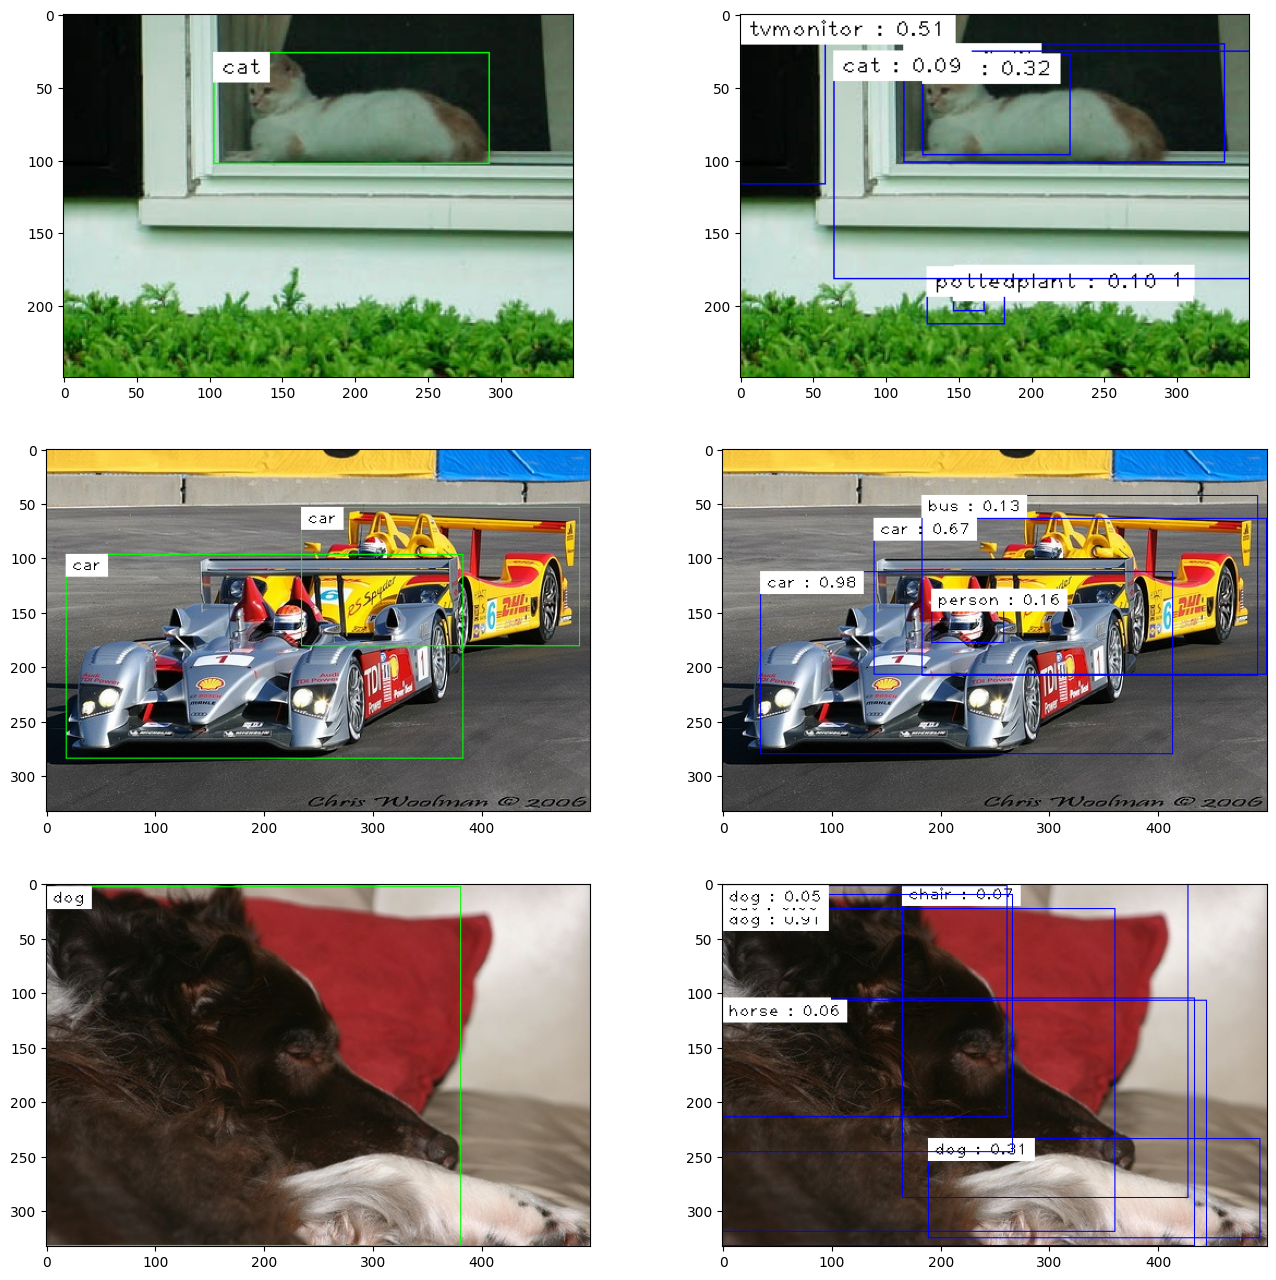

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

for sample_count in tqdm(range(3)):
    random_idx = random.randint(0, len(voc_test))
    im, target, fname = voc_test[random_idx]
    im = im.unsqueeze(0).float().to(device)

    gt_im = cv2.imread(fname)
    gt_im = cv2.cvtColor(gt_im, cv2.COLOR_BGR2RGB)
    gt_im_copy = gt_im.copy()
    
    # Saving images with ground truth boxes
    for idx, box in enumerate(target['bboxes']):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
        # cv2.rectangle(gt_im, (x1, y1), (x2, y2), thickness=2, color=[0, 255, 0])
        cv2.rectangle(gt_im_copy, (x1, y1), (x2, y2), thickness=1, color=[0, 255, 0])
        text = voc.idx2label[target['labels'][idx].detach().cpu().item()]
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, 1, 1)
        text_w, text_h = text_size
        cv2.rectangle(gt_im_copy , (x1, y1), (x1 + 10+text_w, y1 + 10+text_h), [255, 255, 255], -1)
        # cv2.putText(gt_im, text=voc.idx2label[target['labels'][idx].detach().cpu().item()],
        #             org=(x1+5, y1+15),
        #             thickness=1,
        #             fontScale=1,
        #             color=[0, 0, 0],
        #             fontFace=cv2.FONT_HERSHEY_PLAIN)
        cv2.putText(gt_im_copy, text=text,
                    org=(x1 + 5, y1 + 15),
                    thickness=1,
                    fontScale=1,
                    color=[0, 0, 0],
                    fontFace=cv2.FONT_HERSHEY_PLAIN)
    cv2.addWeighted(gt_im_copy, 0.7, gt_im, 0.3, 0, gt_im)
    cv2.imwrite('/kaggle/working/output_frcnn_gt_{}.png'.format(sample_count), gt_im)
    axes.flat[2 * sample_count + 0].imshow(gt_im_copy)
    # plt.imshow(gt_im)

    # Getting predictions from trained model
    rpn_output, frcnn_output = faster_rcnn_model(im, None)
    boxes = frcnn_output['boxes']
    labels = frcnn_output['labels']
    scores = frcnn_output['scores']
    im = cv2.imread(fname)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_copy = im.copy()

    # Saving images with predicted boxes
    for idx, box in enumerate(boxes):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        # cv2.rectangle(im, (x1, y1), (x2, y2), thickness=2, color=[0, 0, 255])
        cv2.rectangle(im_copy, (x1, y1), (x2, y2), thickness=1, color=[0, 0, 255])
        text = '{} : {:.2f}'.format(voc.idx2label[labels[idx].detach().cpu().item()],
                                    scores[idx].detach().cpu().item())
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, 1, 1)
        text_w, text_h = text_size
        cv2.rectangle(im_copy , (x1, y1), (x1 + 10+text_w, y1 + 10+text_h), [255, 255, 255], -1)
        # cv2.putText(im, text=text,
        #             org=(x1+5, y1+15),
        #             thickness=1,
        #             fontScale=1,
        #             color=[0, 0, 0],
        #             fontFace=cv2.FONT_HERSHEY_PLAIN)
        cv2.putText(im_copy, text=text,
                    org=(x1 + 5, y1 + 15),
                    thickness=1,
                    fontScale=1,
                    color=[0, 0, 0],
                    fontFace=cv2.FONT_HERSHEY_PLAIN)
    cv2.addWeighted(im_copy, 0.7, im, 0.3, 0, im)
    cv2.imwrite('samples/output_frcnn_{}.jpg'.format(sample_count), im)
    axes.flat[2 * sample_count + 1].imshow(im_copy)
